In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.mixture import GaussianMixture

In [2]:
def task1():
    # Load data from .npz file
    data = np.load('data.npz')

    # Extract train and test data
    train_data = data['train_data']
    test_data = data['test_data']

    # Generate corruption mask (90% pixel masking)
    S, H, W = test_data.shape
    mask = np.random.choice([0, 1], size=(S, H, W), p=[0.9, 0.1])

    # Return the corruption mask for further usage if needed
    return mask

In [3]:
def fit_gmm(x_train_flattened, K):
    # Fit a Gaussian Mixture Model (GMM) to the flattened training data
    gmm = GaussianMixture(n_components=K)
    gmm.fit(x_train_flattened)
    return gmm

In [4]:
def task2(train_data, K):
    # Reshape train data to 2D array (flatten each image)
    S, H, W = train_data.shape
    train_data_flattened = train_data.reshape(S, H * W)

    # Fit a GMM to the training data and visualize GMM components
    gmm = fit_gmm(train_data_flattened, K)

    # Obtain GMM parameters (means, covariances, and weights)
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_

    # Determine image dimensions (assuming grayscale images)
    feature_dim = H * W

    # Visualize GMM components (means and covariances)
    num_components = len(means)
    fig, ax = plt.subplots(2, num_components, figsize=(2*num_components, 4))

    for k in range(num_components):
        ax[0, k].imshow(means[k].reshape(H, W), cmap='gray')
        ax[0, k].set_title(f'Mean {k+1}')

        # Reshape covariance matrix properly for visualization
        cov_matrix = covariances[k].reshape(feature_dim, feature_dim)
        ax[1, k].imshow(cov_matrix, cmap='gray')
        ax[1, k].set_title(f'Covariance {k+1}')

    plt.suptitle(f'GMM Components (K={K})', fontsize=16)
    plt.tight_layout()
    plt.show()

    return gmm, fig

In [5]:
def conditional_gmm(gmm, test_data):
    # Reshape test data to 2D array (flatten each image)
    S, H, W = test_data.shape
    test_data_flattened = test_data.reshape(S, H * W)

    # Compute posterior probabilities for the test data
    posteriors = gmm.predict_proba(test_data_flattened)

    # Compute posterior expectations (using the means of GMM components)
    posterior_expectations = np.dot(posteriors, gmm.means_)

    return posterior_expectations

In [6]:
def task3(test_data, gmm_params):
    # Unpack GMM parameters obtained from fitting
    gmm = gmm_params  # gmm_params should be the trained GMM model

    # Conditioned GMM: compute posterior expectations for the test data
    S, H, W = test_data.shape  # Get dimensions of test data
    posterior_expectations = conditional_gmm(gmm, test_data)

    # Plotting the results (corrupted, restored, ground truth if available)
    fig, ax = plt.subplots(S, 3, figsize=(12, 4*S))

    
    
    data = np.load('data.npz')

    test_data = data['test_data']

    # Generate corruption mask (90% pixel masking)
    S, H, W = test_data.shape
    mask = np.random.choice([0, 1], size=(S, H, W), p=[0.9, 0.1])

    # Apply mask to each test image (for demonstration)
    corrupted_images = test_data * mask

    for s in range(S):
        ax[s, 0].imshow(corrupted_images[s], cmap='gray')
        ax[s, 0].set_title('Condition')
        ax[s, 1].imshow(posterior_expectations[s].reshape(H, W), cmap='gray')
        ax[s, 1].set_title('Posterior Expectation')

        ax[s, 2].imshow(test_data[s], cmap='gray')
        ax[s, 2].set_title('Ground Truth ')

        

        for a in ax[s]:
            a.axis('off')

    plt.tight_layout()
    plt.show()

    return fig

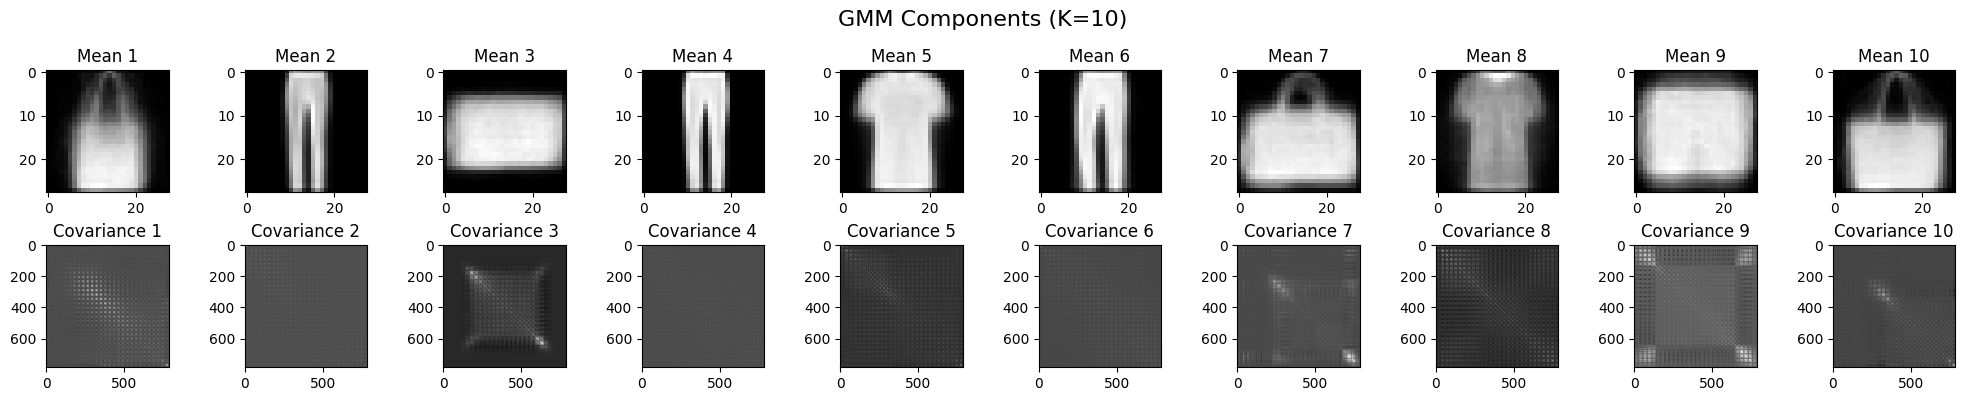

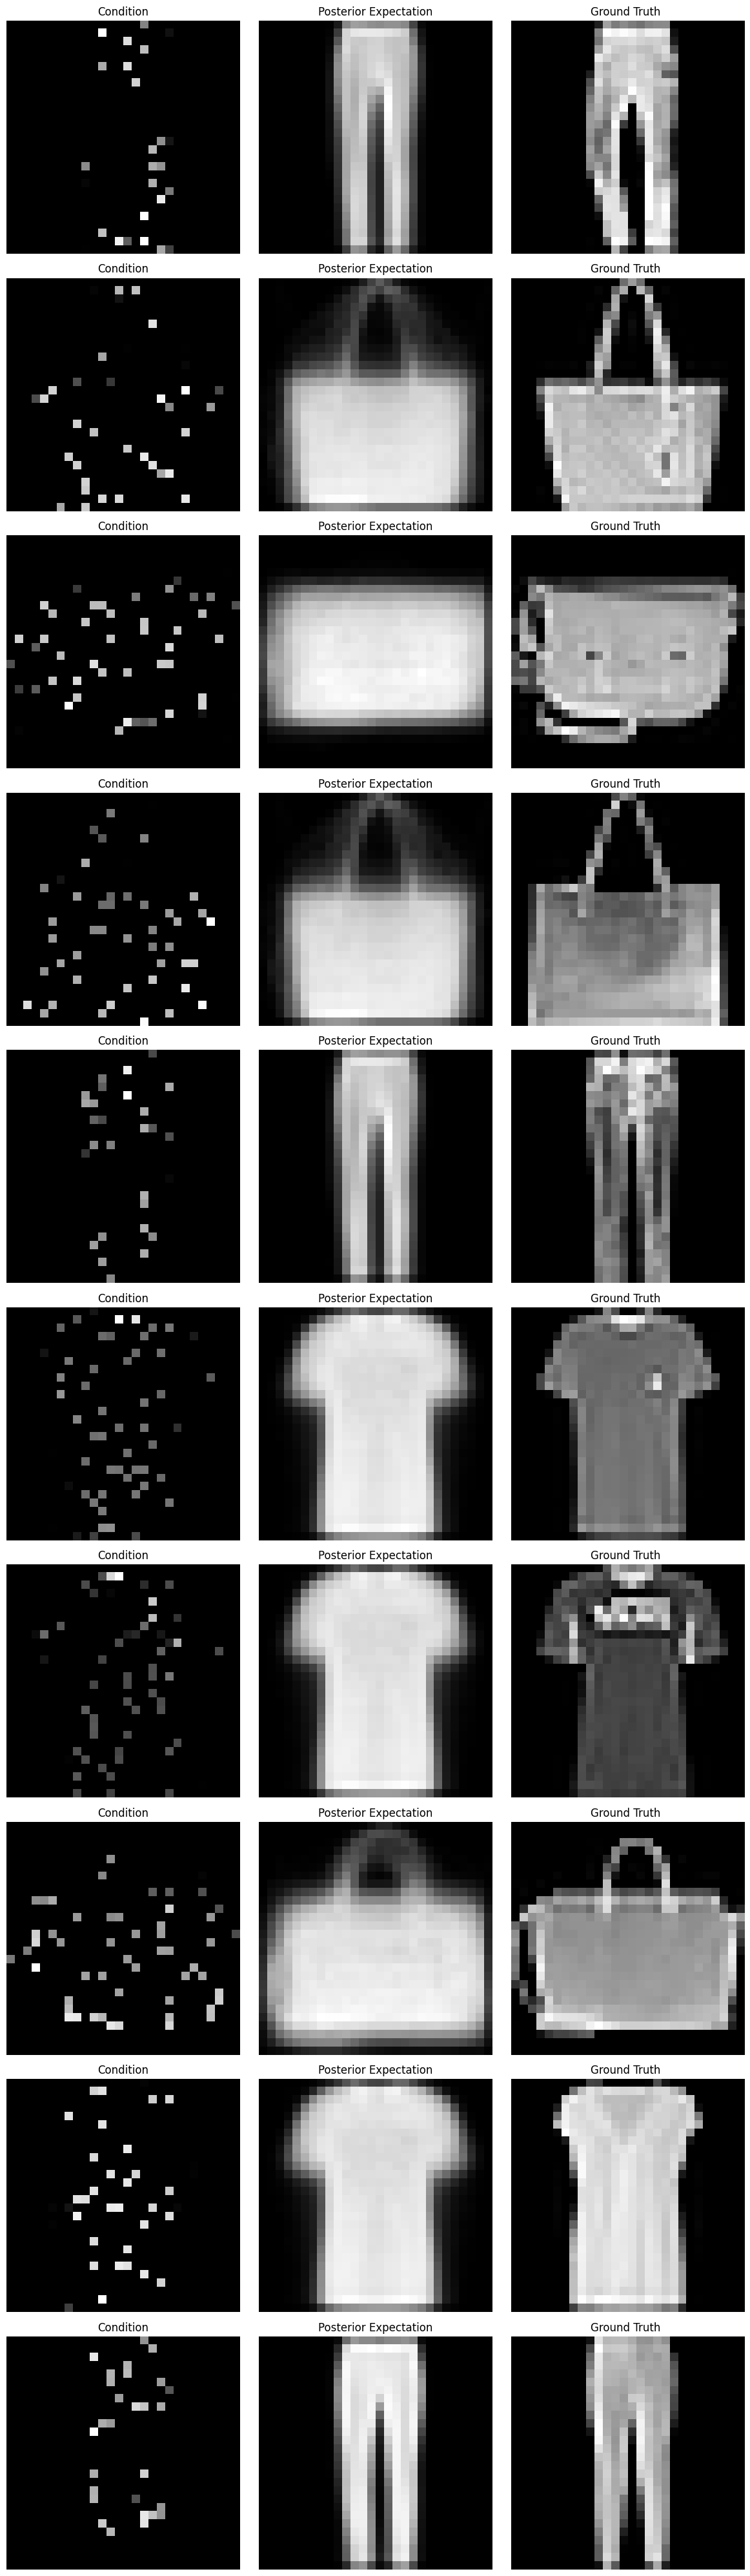

In [7]:
if __name__ == '__main__':
    pdf = PdfPages('figures.pdf')

    # Task 1: Generate corruption mask
    mask = task1()

    # Load train and test data (assuming train_data and test_data are keys in data.npz)
    try:
        with np.load("data.npz") as data:
            if "train_data" in data and "test_data" in data:
                train_data = data["train_data"]
                test_data = data["test_data"]
            else:
                raise ValueError("Missing 'train_data' or 'test_data' in data.npz")
    except Exception as e:
        print(f"Error loading data.npz: {e}")
        train_data = None
        test_data = None

    if train_data is not None and test_data is not None:
        # Task 2: Fit GMM to training data and visualize GMM components
        K = 10  # Number of GMM components (adjust as needed)
        gmm_params, fig1 = task2(train_data, K)

        # Task 3: Image restoration using conditional GMM
        fig2 = task3(test_data, gmm_params)

        # Save figures to PDF
        pdf.savefig(fig1)
        pdf.savefig(fig2)
        pdf.close()
    else:
        print("Data loading failed. Check the content of data.npz and the keys.")